In [1]:
%load_ext autoreload
%autoreload 2
import itertools
import random
import numpy as np
from music21 import *
import schillinger.rhythm as SR
import schillinger.pitch as SP
import matplotlib.pyplot as plt
import math
%load_ext music21.ipython21

In [42]:
class SecondaryAxis:
    
    def __init__(self, motion_sequence, T, P, ascribed_inscribed, time_scale=1,motion_scale=1 ):
        self.sequence_list = []
        self.time_pointer = 0
        self.combinePA(motion_sequence,T,P, ascribed_inscribed, time_scale,motion_scale)
        self.T = T
        self.P = P
        self.time_scale = time_scale
        
    def combinePA(self, ms, T, P, ascribed_inscribed, time_scale, motion_scale):
        
        for i in range(len(ms)):
            self.sequence_list.append(self.calculate_seq(ms[i], 
                                                         T[i%len(T)] * time_scale, 
                                                         P[i%len(P)]*motion_scale,
                                                         ascribed_inscribed[i]))
            
    def calculate_seq(self, motion_type, T, P, a_i):
        
        temp_list = []
        mt = []
        if motion_type == "A":
            mt = [0, 0 + P]
        elif motion_type == "B":
            mt = [0 + P, 0]
        elif motion_type == "C":
            mt = [0 - P, 0]
        elif motion_type == "D":
            mt = [0, 0 - P]
        elif motion_type == "0":
            mt = [0, 0]
            
        temp_list.append(motion_type)
        temp_list.append(["RelativeTime",T])
        temp_list.append(["RelativePitch",mt])
        temp_list.append(["AbsoluteTime",[self.time_pointer, self.time_pointer + T]])
        temp_list.append(a_i)
        self.time_pointer+=T
        
        return temp_list
    
    def getMergedMotionSequence(self):
        temp_T=[]
        for i in self.sequence_list:
            temp_T.append(i[0])
        return list(itertools.chain(*temp_T))
    def getMergedRelativeTime(self):
        temp_T=[]
        for i in self.sequence_list:
            temp_T.append(i[1][1])
        return list(itertools.chain(*temp_T))
    def getMergedAbsoluteTime(self):
        temp_T=[]
        for i in self.sequence_list:
            temp_T.append(i[3][1])
        return list(itertools.chain(*temp_T))
    def getMergedRelativePitch(self):
        temp_P=[]
        for i in self.sequence_list:
            temp_P.append(i[2][1])
        return list(itertools.chain(*temp_P))
    def getSequenceLength(self):
        return sum(self.T)*self.time_scale
    def getHighestPitch(self):
        return max(self.self.sequence_list[:])
    def getLowestPitch(self):
        return min(self.P)
    

class Melody:
    def __init__(self, secondary_axis, melody_rhythm, oscillation=False):#
        self.oscillation = oscillation
        self.melody_corr_len = self.correctMelodyRhythmLength(melody_rhythm, secondary_axis.getMergedAbsoluteTime()[-1])
        self.melody_absolute_time = self.convertRelativeToAbsolute(self.melody_corr_len)
        self.melody_binary = self.convert_to_binary(self.melody_corr_len)
        self.melody_XY = self.convertMelodyToXY(secondary_axis.sequence_list, self.melody_absolute_time)
        self.splitted_XY = self.splitXY(self.melody_XY)
        #print("3 ",self.splitted_XY, self.melody_XY)
        self.melody_ton_seq = self.convertToTonSequence(self.splitted_XY, self.melody_corr_len)
        #print("4 ",self.splitted_XY, self.melody_XY)
        self.oscillated_seq = self.applyOscillation(self.melody_ton_seq)
        return
    def correctMelodyRhythmLength(self,resultant,length):
        r = []
        for i in range(length):
            if(sum(r)<length):
                r.append(resultant[i%len(resultant)])
            else:
                break
        return r #len(resultant)==len(seq_lentgh)
    def convertRelativeToAbsolute(self, resultant):
        #convert "resultant" relative to absolute time
        time_pointer = 0
        abs_resultant = [0]
        for i in resultant:
            abs_resultant.append(i+time_pointer)
            time_pointer+=i
        return abs_resultant # 0,1,2,2 -> 0,1,3,5
    def convert_to_binary(self, data): # converting numbers  1 1 1 1 to oscillation 1 0 1 0 or 3 2 to 1 1 1 0 0
        plot_array = []
        bit = 1
        plot_array.append(0)
        for i, e in enumerate(data):
            seq = [bit%2]*e
            for s in seq:
                plot_array.append(s)
            bit+=1
        return plot_array
    def convertMelodyToXY(self, sequence_list, resultant):
        #pffff
        weighted_abs_resultant = []
        #weighted_abs_resultant = np.zeros(shape=(len(resultant),2))
        for i,e in enumerate(sequence_list):

            X_temp_end = e[3][1][1]
            X_temp_start = e[3][1][0]
            X_steps = X_temp_end - X_temp_start

            Y_start = e[2][1][0]
            Y_stop = e[2][1][1]
            Y_range = Y_start if (Y_start!=0) else Y_stop
            Y_reverse = True if Y_range is Y_start else False

            Y_range_steps = Y_range/X_steps

            X_count = range(X_steps,0,-1) if Y_reverse else range(0,X_steps)
            count=0
            for r in X_count:
                X = X_temp_start+count
                if X in resultant:
                    Y = r * Y_range_steps
                    #convert to ascribed or inscribed motion
                    if(e[4]=='ascribed' and (e[0] is "A" or e[0] is "B")):
                        Y = np.ceil(Y)
                    elif(e[4]=='inscribed' and (e[0] is "A" or e[0] is "B")):
                        Y = np.floor(Y)
                    elif(e[4]=='ascribed' and (e[0] is "C" or e[0] is "D")):
                        Y = np.floor(Y)
                    elif(e[4]=='inscribed' and (e[0] is "C" or e[0] is "D")):
                        Y = np.ceil(Y)
                    else:
                        Y = np.floor(Y)
                        
                    weighted_abs_resultant.append([X,Y])
                count+=1

        return np.array(weighted_abs_resultant,dtype=np.int32) #
    def splitXY(self, melody):
        #print("MELODY SPLITTIBG ", melody)
        x_vals = []
        y_vals = []
        for i,r in enumerate(melody):
            x_vals.append(r[0])
            y_vals.append(r[1])
        return [x_vals, y_vals] #
    def convertToTonSequence(self, melody, melody_lengths):
        melody_xy = np.array(melody)
        melody_xy[0]=melody_lengths
        #print("converting ", len(melody_xy[0]), len(melody_lengths))
        return melody_xy #
    def sinusCycle(self, steps, amplitude, cycles, full_cycle=True, sin=True):
    
        if full_cycle:
            magnitude = 360
        else:
            magnitude = 180

        R = np.array(np.sin(np.arange(0, magnitude, magnitude/steps) * np.pi / 180.)*amplitude, dtype=np.float32)

        if not sin:
            R = np.roll(R, int(steps/2))

        if steps<0:
            R = np.negative(R)

        return np.tile(np.array(np.rint(R), dtype=np.int32), cycles)
    def applyOscillation(self, ton_seq):
        seq = ton_seq.copy()
        #generatie oscillation
        #random.choice([True])
        
        divider = int(100 * float(40)/float(len(ton_seq[1])))
        #print(divider)
        divider = 4
        temp_y = np.array(ton_seq[1])
        #print(temp_y.max())
        oscillation = self.sinusCycle(len(temp_y)/divider, int(temp_y.max()/2), divider, 
                                      full_cycle=random.choice([True,False]), 
                                      sin=True)
        
        #print(temp_y+oscillation)
        
        osc = oscillation.copy()
        osc.resize(temp_y.shape)
        seq[1] = temp_y+osc
        if self.oscillation:
            return seq
        else:
            return ton_seq
    

In [47]:
#GENEATE AXIS
sr_1 = SR.Type_I([7,4])
sr_2 = SR.Type_II([5,4])
motion_sequence=[]
motions=["A","B","C","D","0"]
for m in sr_1.resultant:
    motion_sequence += motions[m%len(motions)-1]

#motion_sequence = "ABBCAAD0DCA"
a_i = ['ascribed','inscribed']
asc_inscribed_motions = [random.choice(a_i) for _ in motion_sequence]
time_seqence = sr_1.resultant
pitch_sequence =sr_2.resultant

SA = SecondaryAxis(motion_sequence, time_seqence, pitch_sequence, asc_inscribed_motions, time_scale=3,motion_scale=2)

In [48]:
#GENEATE MELODY
mel_rythm = SR.Type_II([4,3]).resultant#[2,1,1,1,1,2,4,1,1,2,2,1,1,4]
ME = Melody(SA, mel_rythm, oscillation=False)
#ME.splitted_XY, ME.melody_XY
#ME.melody_ton_seq

In [49]:
#math.ceiling(x) #Round up:  where x is a float type (decimal, basically)
#math.floor(x) #Round down: where x is again a float type

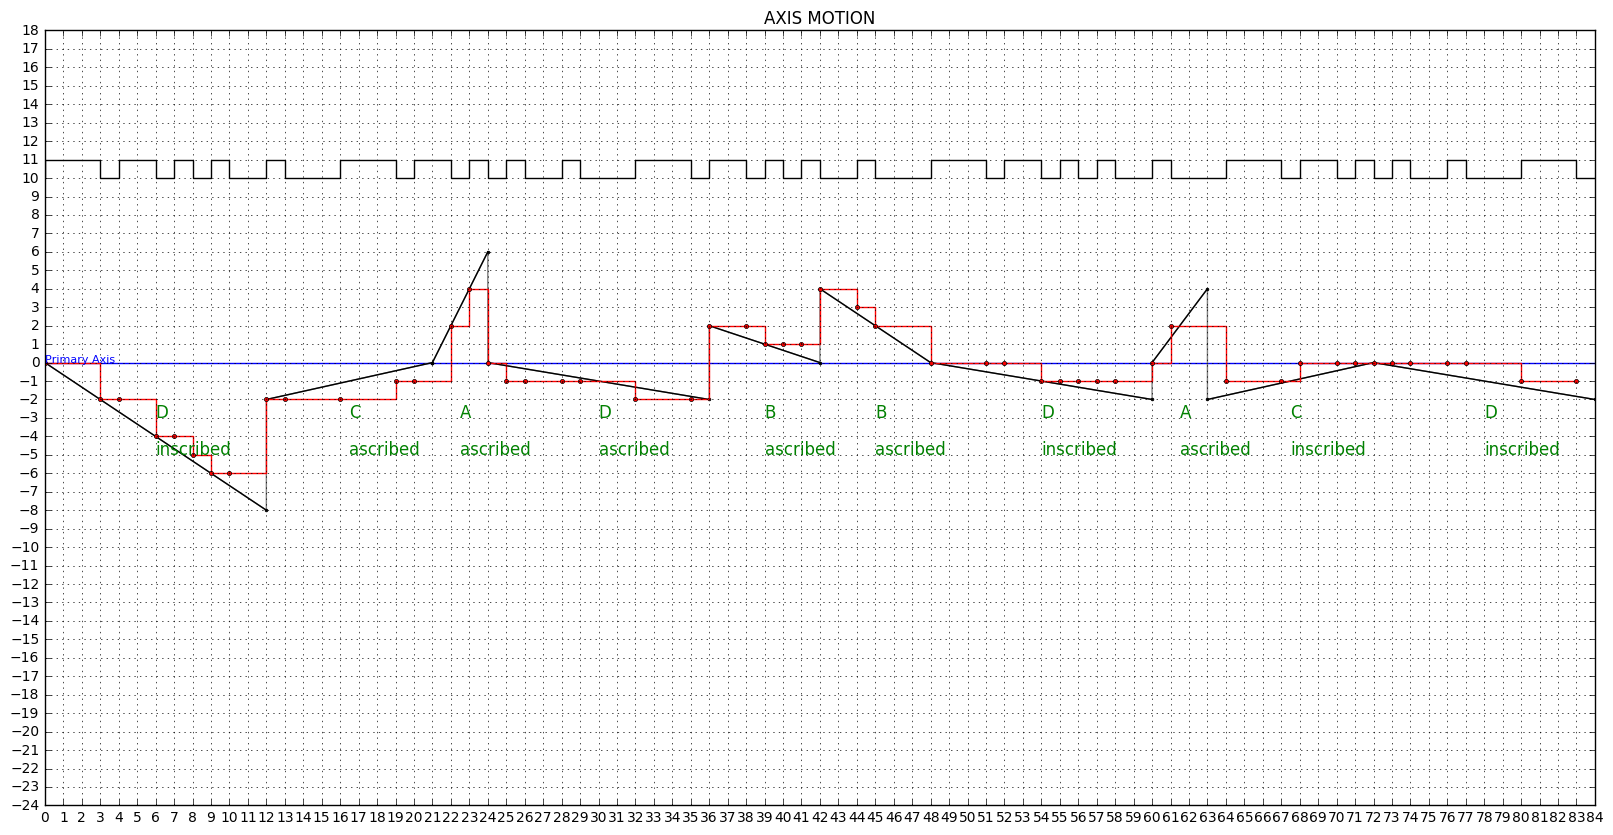

In [50]:
#PLOT
x = SA.getMergedAbsoluteTime()
y = SA.getMergedRelativePitch()
last_number = SA.getMergedAbsoluteTime()[-1]
highest = max(SA.getMergedRelativePitch())
lowest = min(SA.getMergedRelativePitch())

###PLOT
plt.title("AXIS MOTION")
major_ticks = np.arange(-50, 100, 1)
plt.axes().set_xticks(major_ticks)
plt.axes().set_yticks(major_ticks)
plt.plot([0, last_number], [0,0],color="blue")
plt.text(0, 0, "Primary Axis", fontsize=8,color="blue")


#whole SA Motion
plt.plot(x, y,color="grey")
#separate SA Motion
for e,sl in enumerate(SA.sequence_list):
    plt.plot(sl[3][1], sl[2][1], color="black", marker = 'o',markersize=2)
    text_position_x = ((sl[3][1][1]-sl[3][1][0])/2)+sl[3][1][0]
    text_position_y = 0#((sl[2][1][1]-sl[2][1][0])/2)+sl[2][1][0]
    plt.text(text_position_x, text_position_y-3, sl[0], fontsize=12,color="green")
    plt.text(text_position_x, text_position_y-5, sl[4], fontsize=12,color="green")

    
#melody binary
plt.step(range(sum(ME.melody_corr_len)+1), [x+10 for x in ME.melody_binary], color='black')

#aplied resultant
x_vals = []
y_vals = []
for i,r in enumerate(ME.melody_XY):
    x_vals.append(r[0])
    y_vals.append(r[1])
    
melody_Y = ME.oscillated_seq[1]
melody_X = ME.splitted_XY[0]

plt.step(melody_X, melody_Y, where='post',color='red',marker = 'o',markersize=3)

####
plt.grid(which="both")
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([0, last_number, lowest*3, highest*3])
plt.rcParams['figure.figsize'] = (20,20)
plt.show()

In [51]:
#Melody show helpers
def convert_to_music21_sequence(sc, pitches, durations):
    note_seq = []
    tonic = sc.getTonic()
    
    for e, p in enumerate(pitches):
        #c = sc.pitchFromDegree(p+1)
        if p != 0:
            c = sc.next(tonic, direction=p)
        else:
            c = tonic

        nota = note.Note(c.nameWithOctave)
        if p >= 0:
            nota.octave = 4
        else:
            nota.octave = 3
        nota.duration.quarterLength = int(durations[e])
        note_seq.append(nota)
    return note_seq
# simple notes show
def showNotes(note_sequece, time_meter, duration_divider):
    TS = str(time_meter[0])+'/'+str(time_meter[1])
    s = stream.Score(id='mainScore')
    p0 = stream.Part(id='part0')
    p0.timeSignature = meter.TimeSignature(TS)
    for i, notes in enumerate(note_sequece):
        notes.quarterLength = notes.quarterLength*duration_divider
        p0.append(notes)
    s.insert(0, p0)
    return s

In [52]:
#Show Melody Notes
melody = ME.oscillated_seq
hm = scale.HarmonicMinorScale("C4")
pitches = convert_to_music21_sequence(hm, melody[1], melody[0])
s = showNotes(pitches,[4,4],1)
s.show('musicxml')

In [53]:
# notes harmony 

def arpeggiator(c, es,rhythm, duration_divider):
    chords = []
    for i, seq in enumerate(c):
                
        nota = seq
        nota.duration.quarterLength = (rhythm[es%len(rhythm)]/len(c)) * duration_divider
        chords.append(nota)

    nota = pitch.Pitch(c.pitches[0])
    
    
    nota.octave = nota.octave + 2
    nota = note.Note(nota.nameWithOctave)
    #nota.duration.quarterLength = rhythm[es%len(rhythm)] * duration_divider
    nota.duration.quarterLength = (rhythm[es%len(rhythm)]/len(c)) * duration_divider
    
   
    chords.append(nota)
    #octave adjust
    
    
    #print(chords[-1].pitch.midi - chords[-2].pitch.midi, chords[-1])
    if chords[-1].pitch.midi - chords[-2].pitch.midi >= 11:
        chords[-1].octave = chords[-1].octave -1
        #print("yes")
    ##
    nota = pitch.Pitch(c.pitches[2])
    nota.octave = nota.octave
    nota = note.Note(nota.nameWithOctave)
    #nota.duration.quarterLength = rhythm[es%len(rhythm)] * duration_divider
    nota.duration.quarterLength = (rhythm[es%len(rhythm)]/len(c)) * duration_divider
    chords.append(nota)
    return chords

def showHarmony(pitches, note_sequence, scala, rhythm, length, time_meter, duration_divider, arp=False,bass=True, drop2 = False):
    TS = str(time_meter[0])+'/'+str(time_meter[1])
    
    s = stream.Score(id='mainScore')
    p0 = stream.Part(id='melody')
    p0.timeSignature = meter.TimeSignature(TS)
    p1 = stream.Part(id='chords')
    p1.timeSignature = meter.TimeSignature(TS)
    
    #pseudo stuff
    #temp_scale = scala
    #rhythm_seq = [2,1,1,2]
    for es, sequences in enumerate(note_sequence):
        
        melody = []
        chords = []
        
        
        
        ### chords
        #chord_seq = [sequences[0]]+sequences[1]
        chord_seq = sequences
        #print(chord_seq)
        test_chord = chord.Chord(chord_seq)
        c = chord.Chord(test_chord)
        #c.root = sequences[0]
        #pitches[es].quarterLength.duration
        c.quarterLength = pitches[es].quarterLength * duration_divider
        #c = c.sortDiatonicAscending() # for better voice leadng but not real!
        #c.pitches.octave = 2
        for p in c.pitches:
            p.octave = 3
        if drop2:
            try:
                #
                #c.pitches[0].octave = 1 # drop2
                #c.pitches[-2].octave -= 2 # drop4
                pass
            except:
                pass
        
        if arp:
            chords =  arpeggiator(c, es, rhythm, duration_divider)
            #chords.append(nota)
            
        else:
            chords.append(c)
            
        nota = pitches[es]
        nota.quarterLength *= duration_divider
        #nota.octave += 1 
        melody.append(pitches[es])
            
        
        ##############
        # pseudo BASS
        # get chord durations and apply on melody (for test purpose)
        
        p0.append(melody)
        p1.append(chords)
        
    
    s.insert(0, p0)
    s.insert(0, p1)
    
    #s = s.transpose(0)
    return s



In [54]:
#'harmonized'
def harmonize_note_clockwise(note, chordified_scale, clock_position):
    dummy = []
    for i in range(len(chordified_scale)):
        check_note = chordified_scale[i][clock_position % len(chordified_scale[i])]
        if str(check_note) == str(note):
            #print(note, chordified_scale[i][clock_position%len(chordified_scale[i])])
            dummy.append(chordified_scale[i])
            break
    return dummy

melody = ME.oscillated_seq
hm = scale.HarmonicMinorScale("C4")
notes = convert_to_music21_sequence(hm, ME.melody_ton_seq[1], ME.melody_ton_seq[0])
note_seq = [[str(p.name) for p in notes]]

temp_scale = [str(p.name) for p in hm.pitches[:-1]]
scales = [temp_scale]
#print(scales)
#note_seq = bass
voice_amount = 3 
theme_expansion = 0
scale_expansion_amount = 1 # # 1st order expansion for harmonizing is according to schillingers default

SPG = SP.PitchGroup()
harmonized_note_sequence_array = []
scale_expansion = SPG.expansions(temp_scale)
scale_ = scale_expansion[scale_expansion_amount]
chordified_scale = SPG.chordify_scale(scale_, voice_amount)

for i,e in enumerate(note_seq[0]):
    clock_position = i
    hn = harmonize_note_clockwise(e, chordified_scale, clock_position)
    harmonized_note_sequence_array.append(hn)
    
merged_seq = list(itertools.chain(*harmonized_note_sequence_array))
s = showHarmony(notes,merged_seq, hm, melody[0], len(merged_seq)*2, (4,4), 0.5, arp=False, bass=False, drop2=True)
s.show('musicxml')

In [ ]:
#np.negative(np.arange(-5, 0, 1))
#random.choice([a.min(),a.max()])
#random.choice([True,False])
#np.random.randint(0,PA.durations[i])

In [ ]:
#OSCILLATOR

def sinusCycle(steps, amplitude, cycles, full_cycle=True, sin=True):
    
    if full_cycle:
        magnitude = 360
    else:
        magnitude = 180
    
    R = np.array(np.sin(np.arange(0, magnitude, magnitude/steps) * np.pi / 180.)*amplitude, dtype=np.float32)
    
    if not sin:
        R = np.roll(R, int(steps/2))
    
    if steps<0:
        R = np.negative(R)
        
    return np.tile(np.array(np.rint(R), dtype=np.int32), cycles)

def growSeq(np_array, start_amount=1, end_amount=5):
    c = np_array.copy()
    dummy = np.linspace(start_amount, end_amount, len(np.nonzero(c)[0]), endpoint=True, dtype=np.int32)
    c[np.nonzero(c)] *= dummy
    return c

def shiftSeq(np_array, start_amount=0, end_amount=1):
    c = np_array.copy()
    dummy = np.linspace(start_amount, end_amount, len(c), endpoint=True, dtype=np.int32)
    c += dummy
    return c

steps=4
amplitude = 1
cycles = 1
X = sinusCycle(steps, amplitude, cycles, full_cycle=True, sin=True)
X
Y = growSeq(X, start_amount=1, end_amount=2)
Y